# **Packages**

In [1]:
#%pip install tensorflow-gpu==2.9
#%pip install tensorflow-text

In [2]:
import tensorflow as tf
import tensorflow_text as tf_text

In [3]:
#%pip install matplotlib

In [4]:
import pandas as pd
import gzip
import gc
import numpy as np
from tensorflow import keras
from sklearn.model_selection import KFold
import datetime 
import os
import matplotlib.pyplot as plt


In [5]:
#%pip install gensim==4.2
#%pip install nltk

In [6]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api
from nltk.tokenize import sent_tokenize, word_tokenize


In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mobin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2022-11-16 11:38:37.842255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:38:37.861142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:38:37.861308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:38:37.862166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

1 Physical GPUs, 1 Logical GPUs


2022-11-16 11:38:37.863496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:38:37.863652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:38:37.863761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:38:38.166647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:38:38.166806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [9]:
# %pip install tensorboard
# %pip install -U tensorboard_plugin_profile

In [10]:
#tf.config.optimizer.set_jit(True)


# **Data Extraction**

In [11]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    name=b'"verified": \"true\",'
    l=l.replace(b'"verified": true,',bytes(name))
    name1=b'"verified": \"false\",'
    l=l.replace(b'"verified": false,',bytes(name))
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/home/mobin/Downloads/reviews_Grocery_and_Gourmet_Food_5.json.gz')

# dataset link
# Grocery and Gourmet Food
# https://jmcauley.ucsd.edu/data/amazon/

Dataset Schema

In [12]:
df.rename(columns={"reviewerID": "userID", "asin": "itemID","overall":"rating"},inplace=True)
df=df[['userID','itemID','reviewText','rating']]
df

,userID,itemID,reviewText,rating
0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4.0
1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3.0
2,A27IQHDZFQFNGG,616719923X,Really good. Great gift for any fan of green t...,4.0
3,A31QY5TASILE89,616719923X,"I had never had it before, was curious to see ...",5.0
4,A2LWK003FFMCI5,616719923X,I've been looking forward to trying these afte...,4.0
...,...,...,...,...
151249,A2L6QS8SVHT9RG,B00KCJRVO2,Delicious gluten-free oatmeal: we tried both t...,4.0
151250,AFJFXN42RZ3G2,B00KCJRVO2,With the many selections of instant oatmeal ce...,4.0
151251,ASEBX8TBYWQWA,B00KCJRVO2,"While I usually review CDs and DVDs, as well a...",5.0
151252,ANKQGTXHREOI5,B00KCJRVO2,My son and I enjoyed these oatmeal packets. H...,4.0


# **Data Splitting**

In [13]:
current_fold=10
kfold = KFold(10)
random_iterator=kfold.split(df)
for i in range(current_fold):
  train_index, test_index = next(random_iterator, None)
  print(train_index,len(train_index))
  train_df, test_df =df.iloc[train_index], df.iloc[test_index]


[ 15126  15127  15128 ... 151251 151252 151253] 136128
[     0      1      2 ... 151251 151252 151253] 136128
[     0      1      2 ... 151251 151252 151253] 136128
[     0      1      2 ... 151251 151252 151253] 136128
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 136126 136127 136128] 136129


In [14]:
train_df

,userID,itemID,reviewText,rating
0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4.0
1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3.0
2,A27IQHDZFQFNGG,616719923X,Really good. Great gift for any fan of green t...,4.0
3,A31QY5TASILE89,616719923X,"I had never had it before, was curious to see ...",5.0
4,A2LWK003FFMCI5,616719923X,I've been looking forward to trying these afte...,4.0
...,...,...,...,...
136124,A74CGCGJ11Y23,B009M516NE,I've made rice pilaf from scratch. I've also t...,4.0
136125,A36MP37DITBU6F,B009M516NE,This is a slightly mild flavored rice pilaf. t...,4.0
136126,A1JBBR4MNGQ70G,B009M516NE,I added a package of Albacore tuna to this mix...,3.0
136127,A2P739KOM4U5JB,B009M516NE,I am happy to report that Side Mates were grea...,4.0


# **Data Analysis**

**User Data**

determining all unique users with their reviews and ratings

In [15]:
user_df=df[['userID','reviewText','rating']].groupby('userID')['rating','reviewText'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
user_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,userID,reviewText,rating
0,A00177463W0XWB16A9O05,[It is a good stand by coffee you can count on...,"[5.0, 5.0, 4.0, 4.0, 5.0, 3.0, 4.0, 5.0, 5.0, ..."
1,A022899328A0QROR32DCT,[awesome texture for even the gluten eating ea...,"[5.0, 1.0, 4.0, 5.0, 5.0, 5.0, 1.0, 2.0, 3.0, ..."
2,A04309042SDSL8YX2HRR7,[I love roasted garlic & sweet bell peppers. Y...,"[5.0, 2.0, 4.0, 4.0, 4.0]"
3,A068255029AHTHDXZURNU,[These bars are especially delicious for cocon...,"[5.0, 5.0, 3.0, 5.0, 3.0, 3.0, 5.0, 5.0, 5.0]"
4,A06944662TFWOKKV4GJKX,[UGH! My stomach has been really killing me l...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0]"
...,...,...,...
14676,AZWRZZAMX90VT,"[Very nice. Not spicy, not too salty, lots of ...","[5.0, 5.0, 2.0, 5.0, 5.0, 4.0, 4.0, 3.0, 4.0, ..."
14677,AZXKAH2DE6C8A,[Could not imagine having such a rich tasting ...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, ..."
14678,AZXON596A1VXC,[I was a bit skeptical when I bought this prod...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
14679,AZYXC63SS008M,[This is just about the healthiest you can get...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"


In [16]:
print(user_df['reviewText'][0])
print(user_df['rating'][0])
# user_df.loc[0][1] --->the same as above code

['It is a good stand by coffee you can count on.  I would reley on it for the daily use catagory.', 'I like the &#34;wake up&#34; factor of this blend.  I could drink it all day long and never get tired of it.', 'I am pleased with the brew, but not enthused.  I have had better for the price, but its ok. Thats it', 'Much better than the Daybreak blend.  Much Bolder taste and better richness.  Could be a lil fresher though.  I would buy it again at lower price.', 'ypiuy y yu 8t 8t o t875t9t uf5o g r6  t9 t7r rf8y0[8uyr  d8oy p0t8y 897 77u7td8t 7t 7ty yr f8', 'It is an ok tea,not the best or worst.  It seems a lil weak if you ask me.  I wish it had a stronger taste!', 'I really went through this off brand coffee.  I found it in the corner of the site,give it a try!It is a great value,and will get it in the future.', 'Impressed with the price and taste of this coffee.  I also like the lower price compared with the competition. Winner!', 'I love the packaging and brew of this coffee.  Yes w

**Item Data**

determining all unique items with their reviews and ratings

In [17]:
item_df=df[['itemID','reviewText','rating']].groupby('itemID')['reviewText','rating'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
item_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,itemID,reviewText,rating
0,616719923X,[Just another flavor of Kit Kat but the taste ...,"[4.0, 3.0, 4.0, 5.0, 4.0, 4.0, 3.0, 5.0, 5.0, ..."
1,9742356831,[This curry paste makes a delicious curry. I ...,"[5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
2,B00004S1C5,[These dyes create awesome colors for kids cra...,"[5.0, 1.0, 5.0, 5.0, 5.0, 4.0, 4.0]"
3,B0000531B7,[I really enjoy these bars as a quick breakfas...,"[5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0]"
4,B00005344V,"[Traditional Medicinals' ""Breathe Easy"" is an ...","[5.0, 3.0, 5.0, 5.0, 3.0, 5.0, 5.0]"
...,...,...,...
8708,B00JGPG60I,[We switched to this formula 5 days ago and fo...,"[4.0, 4.0, 4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 2.0, ..."
8709,B00JL6LTMW,[We have enjoyed Larabar's variety of bars for...,"[4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, ..."
8710,B00K00H9I6,[This 100% pure Canadian maple syrup is a Grad...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
8711,B00KC0LGI8,[I followed the directions on the box exactly ...,"[2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 2.0, 5.0, 3.0, ..."


In [18]:
print(item_df['reviewText'][0])
print(item_df['rating'][0])
# item_df.loc[0][1] --->the same as above code

['Just another flavor of Kit Kat but the taste is unique and a bit different.  The only thing that is bothersome is the price.  I thought it was a bit expensive....', "I bought this on impulse and it comes from Japan,  which amused my family,  all those weird stamps and markings on the package. So that was fun.  It said it would take about a month to arrive and it did take that long.  I was hoping for a more interesting taste but to our family,  it just tasted a bit less flavorful or weaker than the standard milk chocolate kit kat.  The green tea flavor was too subtle for the sugar and it just tasted sweet. The wafers were very crispy, and that was good,  but it tasted a bit anemic to us.I'm happy I bought it, but don't need to buy it again.", 'Really good. Great gift for any fan of green tea! Just so expensive to purchase candy from across the sea.', 'I had never had it before, was curious to see what it was like. Smooth, great subtle good flavor. I am ordering more and plan to make i

##   Ratings

count    151254.000000
mean          4.243042
std           1.090003
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

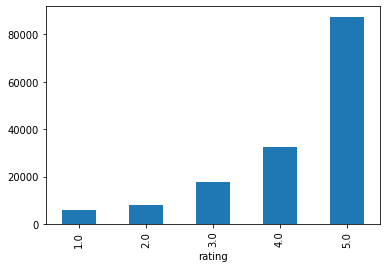

In [19]:
df.groupby('rating').size().plot(kind="bar");
df['rating'].describe()
#histogram of ratings

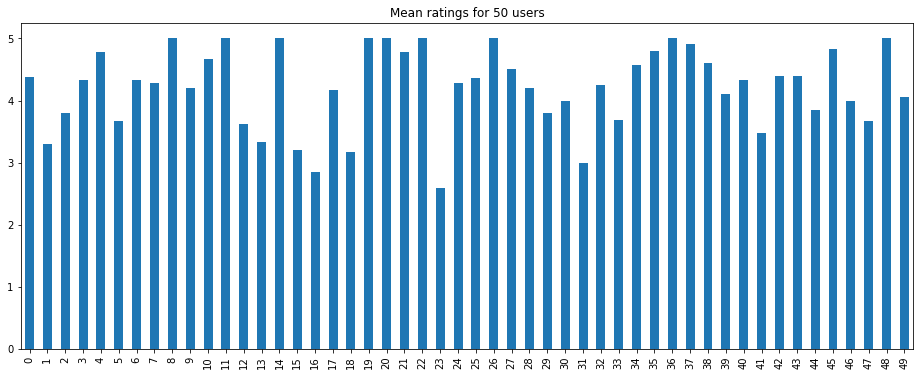

In [20]:
user_means=user_df.rating.apply(lambda x: np.mean(x))
user_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 users");

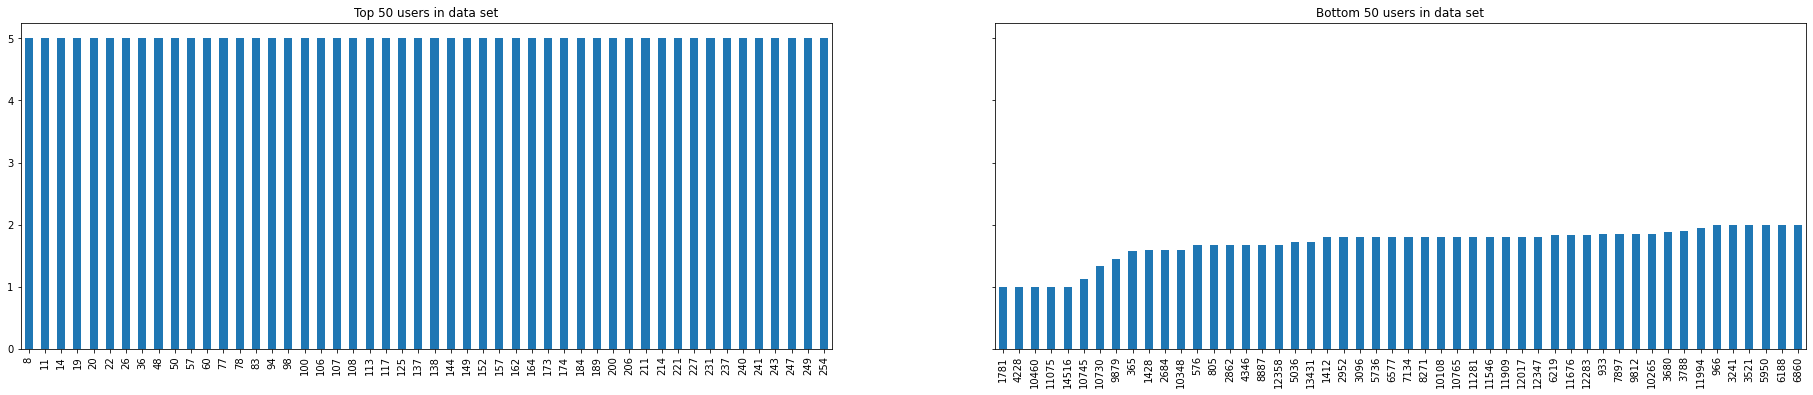

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,6), sharey=True)
user_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 users in data set")
user_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 users in data set");

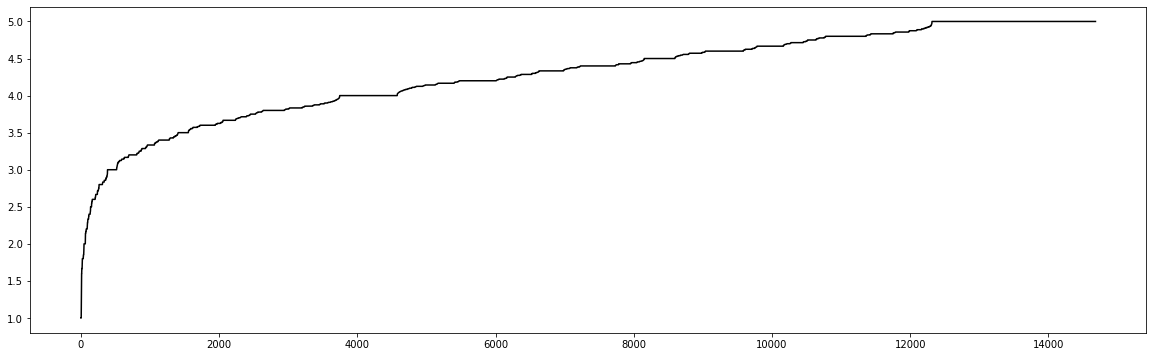

In [22]:
user_means = df.groupby("userID").rating.mean().sort_values()
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(np.arange(len(user_means)), user_means.values, "k-")


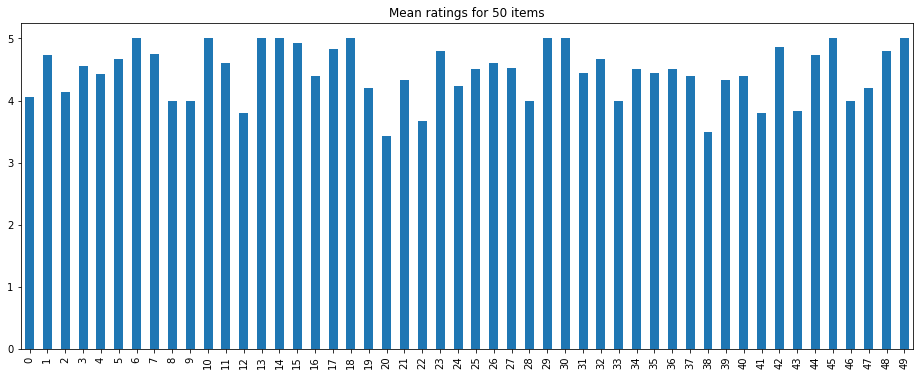

In [23]:
item_means=item_df.rating.apply(lambda x: np.mean(x))
item_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 items");

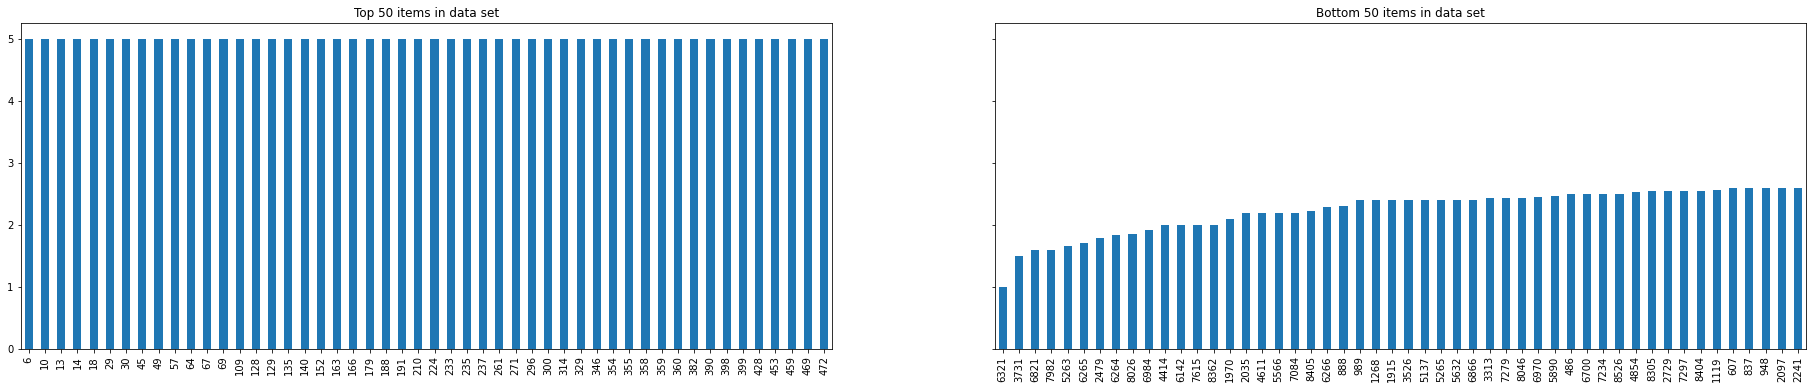

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,6), sharey=True)
item_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 items in data set")
item_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 items in data set");

## Reviews

In [25]:
df['reviewText'].describe()

count     151254
unique    151199
top             
freq          22
Name: reviewText, dtype: object

count    151254.000000
mean        509.002142
std         524.745639
min           0.000000
25%         191.000000
50%         353.000000
75%         644.000000
max       29569.000000
Name: reviewText, dtype: float64

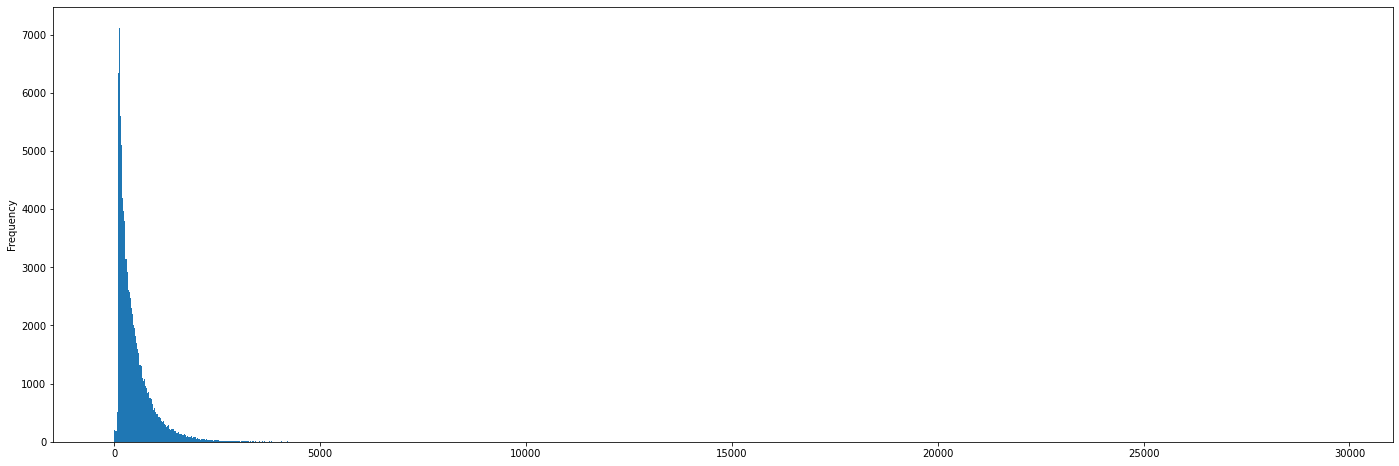

In [26]:
# review length
rv_le=df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()


In [27]:
sum=0
sum2=0
for x in user_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(user_df['reviewText'])
w_mean=sum2/(r_mean*len(user_df['reviewText']))
print('mean of reviews per user:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per user:',r_mean * w_mean)
# plot for reviews per user

mean of reviews per user: 10.302704175464887
mean of words per review: 509.00214209211
mean of words per user: 5244.098494652953


In [28]:
sum=0
sum2=0
for x in item_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(item_df['reviewText'])
w_mean=sum2/(r_mean*len(item_df['reviewText']))
print('mean of reviews per item:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per item:',r_mean * w_mean)

mean of reviews per item: 17.359577642603007
mean of words per review: 509.00214209211
mean of words per item: 8836.062205899232


# **Embedding Matrix**

In [29]:
# hyperparameters
embedding_dim=300
min_frequent_word_num=50
max_vocab_size=5000

In [30]:
def load_word2vec_model():
    if os.path.exists("word2vec.wordvectors"):
        print("loaded from word2vec.wordvectors")
        return KeyedVectors.load("word2vec.wordvectors",mmap='r')
    else:
        # downloading google news word2vec model
        if not os.path.exists("word2vec_google.bin"):
            downloaded_model = api.load('word2vec-google-news-300')
            downloaded_model.save_word2vec_format('word2vec_google.bin',binary=True)
            del downloaded_model
        # loading google news word2vec model
        google_word2vec = KeyedVectors.load_word2vec_format("word2vec_google.bin", binary=True)

       # tokenizing the whole reviews in text_corpus
        text_corpus=[]
        for k in range(len(df['reviewText'])):    # iterate through each sentence in the reviews
            for i in sent_tokenize(df['reviewText'].loc[k]):
                temp = []
                # tokenize the sentence into words          
                for j in word_tokenize(i):
                    temp.append(j.lower())
                text_corpus.append(temp)
                del temp


        # creating a new word2vec model and initializing it from pretrained google_word2vec
        word2vec_model=Word2Vec( text_corpus,max_final_vocab=max_vocab_size,min_count=min_frequent_word_num ,vector_size= embedding_dim,window = 1,workers=16, sg=1,epochs=1)
        word2vec_model.build_vocab(text_corpus)

        word2vec_model.build_vocab([google_word2vec.index_to_key],update=True)
        word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv))
        word2vec_model.wv.intersect_word2vec_format("word2vec_google.bin",binary=True,lockf=1.0)
        
        # fine tuning the model and saving it
        word2vec_model.train(text_corpus, epochs=5, total_examples=word2vec_model.corpus_count)
        word2vec_model.wv.save("word2vec.wordvectors")
        
        del google_word2vec
        del text_corpus[:]
        gc.collect()
  
        return word2vec_model.wv
        

In [31]:
# loading the embedding lookup matrix shape=( 5k ,300 )
embedding_matrix = load_word2vec_model() 

loaded from word2vec.wordvectors


In [32]:
special_token_embedding = np.random.rand(4,embedding_matrix.vector_size)
full_embedding_matrix = np.concatenate((special_token_embedding,embedding_matrix.vectors))
full_embedding_matrix.shape

(5004, 300)

In [33]:
# example
# embedding_matrix['keep']

# **Text Vectorization**

- The conversion of tokens to ids

In [34]:
# hyperparameters
sequence_length=20
review_max_length=100

## Text Preprocessing

In [35]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  #text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

  #sos and eos are not used in docs but we need to add them manually in the decoder

  return text

## Vectorization layer

In [36]:
# input text processor is in charge of maping tokens to ids and vice versa
input_text_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size+4, standardize = tf_lower_and_split_punct, output_sequence_length = review_max_length )

In [37]:
input_text_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )

* some example about how to work with input text processor

In [38]:
# included sos, eos, unk and space 
print("input_text_processor vocab size :" ,len(input_text_processor.get_vocabulary()))
# Here are the first 8 words from the vocabulary:
input_text_processor.get_vocabulary()[:8]

input_text_processor vocab size : 5004


['', '[UNK]', '[START]', '[END]', '.', ',', 'the', 'i']

In [39]:
input_text_processor.get_vocabulary().index('just')

42

In [40]:
input_text_processor.get_vocabulary()[1240]

'sent'

In [41]:
print(item_df['reviewText'][0][0])
print(input_text_processor(  item_df['reviewText'][0][0]  ))

Just another flavor of Kit Kat but the taste is unique and a bit different.  The only thing that is bothersome is the price.  I thought it was a bit expensive....
tf.Tensor(
[   2   42  288   41   12 1527    1   19    6   37   13 1136    9    8
  116  206    4    6   92  246   17   13    1   13    6  118    4    7
  248   10   29    8  116  387    4    4    4    4    3    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int64)


# **Data Transformation**

In [42]:
dt = np.dtype( [('userid', 'int32'), ('itemid', 'int32'),('rating', 'int32'),('review', 'int32',(sequence_length,) )])
tt=np.empty([150, 1], dtype=dt)
tt['rating'][50][0]

3726

In [43]:
train_data=np.empty([train_df.shape[0], ], dtype=dt)
test_data=np.empty([test_df.shape[0], ], dtype=dt)

user_to_row = {}
item_to_column = {}


for i, user_id in enumerate(np.unique(df['userID'])):
    user_to_row[user_id] = i

for j, item_id in enumerate(np.unique(df['itemID'].tolist())):
    item_to_column[item_id] = j

train_rw=input_text_processor(train_df['reviewText'])[:,:sequence_length]
test_rw=input_text_processor(test_df['reviewText'])[:,:sequence_length]
train_rw
test_rw
for index, row in enumerate( train_df[['userID','itemID','rating']].to_numpy()):
   
    train_data['userid'][index]= user_to_row[row[0]]
    train_data['itemid'][index]= item_to_column[row[1]]
    train_data['rating'][index]= row[2]
    train_data['review'][index]=train_rw[index]

for index, row in enumerate( test_df[['userID','itemID','rating']].to_numpy()):
   
    test_data['userid'][index]= user_to_row[row[0]]
    test_data['itemid'][index]= item_to_column[row[1]]
    test_data['rating'][index]= row[2]
    test_data['review'][index]=train_rw[index]

#for index,row in enumerate( train_data):
 # train_data['review'][row]=train_rw[i]
#for i,row in enumerate( test_data):
#  test_data['review'][row]=train_rw[i]
train_data
test_df[['userID','itemID','rating']].to_numpy()

array([['A1U6M8VJHK2ECA', 'B009M516NE', 5.0],
       ['A244CRJ2QSVLZ4', 'B009M516NE', 5.0],
       ['A1SB9BNNGKNX2Z', 'B009M516NE', 3.0],
       ...,
       ['ASEBX8TBYWQWA', 'B00KCJRVO2', 5.0],
       ['ANKQGTXHREOI5', 'B00KCJRVO2', 4.0],
       ['A2CF66KIQ3RKX3', 'B00KCJRVO2', 4.0]], dtype=object)

In [44]:
train_rw[50]

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([   2,    7, 1599,  170,   83,    6, 2656, 4357,   12,   14,   55,
          5,   19,    6,   41,   13, 4950, 4028,    4,    7])>

In [45]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (
       tf.cast(train_data['userid'],tf.int32),
       tf.cast(train_data['itemid'],tf.int32),
       tf.cast(train_data['rating'],tf.int32),  
       tf.cast(train_data['review'],tf.int32)  
    )
).shuffle(1024).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices(
    (
       tf.cast(test_data['userid'],tf.int32),
       tf.cast(test_data['itemid'],tf.int32),
       tf.cast(test_data['rating'],tf.int32),  
       tf.cast(test_data['review'],tf.int32)  

    )
).shuffle(1024).batch(32)

In [46]:
train_data[5]

(2510, 0, 4, [  2,  36,   1,  23,  47,  34,   5,  19,  43,   1, 276,  16,   8, 189, 250,  55,  41,  18,  62,  40])

In [47]:
for i, batch in enumerate( test_ds ):
    print(batch[0])

tf.Tensor(
[ 4000   548 11970  2462   417  8897 14030  2447    93   534  4930 10795
  7340 12084 13502 12692  5062  2736  9170  3618  3345  2149   177  3326
  3250 12920 10123 12233  2977 11815  2879  9378], shape=(32,), dtype=int32)
tf.Tensor(
[ 3742 11935  8949 11970 13515  4275  2653  5545 10210  7041  5779  2411
 13375  5250 12466   909  1039 11916 13273 11626  2977  3735  7558  7839
 13859 13490  7609  8767   886  5718  6631  8198], shape=(32,), dtype=int32)
tf.Tensor(
[13487  8746  4817 12322 13914 11477 14635  8283  5729  6849  3218  2302
    12  4462  3358  2755  9147  4729   713 13763  2904  1266   756   861
 12771  6666  4813  8849  2202 10341  2363  8994], shape=(32,), dtype=int32)
tf.Tensor(
[13051   466  2968  5509  3840  5721  3384  7523 11924  1090  4242 13557
 14437  1622  1045 14051  1030 11814  8982  8908  1205  9143  1842 10198
 11883  9466  8430 11776  3163  3785  9116  3436], shape=(32,), dtype=int32)
tf.Tensor(
[ 8294 11458  8129 10987  2180 14534  1030  5650  541

## Creating User and Item Documents

**User Documents**

In [48]:
user_doc=[]
for mydoc in user_df['reviewText']:
   user_doc.append( input_text_processor(  mydoc ))


In [49]:
user_doc[7000]

<tf.Tensor: shape=(5, 100), dtype=int64, numpy=
array([[   2,   27,   65,  966,   25,  329,    5,   14,  450,  100,   16,
        1377,  318,    5,   19,   21,  513,    4,    7,  119,   15,    1,
           9,   63,  203,    5,  200,  348,    5,   19,   43,   71,    1,
           8,  153,   12,   65,  161,  273,   32,   15,  819,   18,   23,
         488,    5,   18,   23,  273,   11,   37,    6,  763,  373,    4,
           7,  585,   18,   25,   11,  272,   49,   10,  209,    8,  116,
           4,    6,  897,  353,  485,   32,    6,  283,   12,    6,  129,
          13,   47,   34,    5,  187,    7,  120, 4058, 4526,  350,   12,
         156,    7,  180,   17,    4,   27,  257,   27,   18,    1,  803,
          14],
       [   2,   14,  368,   13,   16,    6,   61,    5,   19,   21,    6,
         118,    4,   18,   50,  124,   10,   49,  112,  345,  148,  224,
          16,   83,  331,    6,  118,    4,  378,   18,  108,   10,  187,
           5,  858,   11,   40,    1,    4,   14,

**Item Documents**

In [50]:
item_doc=[]
for mydoc in item_df['reviewText']:
   item_doc.append( input_text_processor(  mydoc ))

In [51]:
item_df['reviewText'][0][4]

"I've been looking forward to trying these after hearing about how popular they were in Japan, and among Kit Kat fans as well. I do not recommend ordering these during warm weather, because they can melt and become smushy. I ordered mine right when summer began, and they were a bit mushy so I let them solidify under room temp. Afterwards, I tried some and they tasted fine. I was expecting a stronger green tea or matcha flavor, but it is actually quite subtle. The outer coating was creamy and not overly sugary, which I liked. Overall, I wouldn't say it's insanely good, but definitely a yummy treat."

In [52]:
item_doc[5004]

<tf.Tensor: shape=(12, 100), dtype=int64, numpy=
array([[   2,    6, 1381, ...,   69, 1769,    1],
       [   2,    6,   55, ...,  182,   12,   55],
       [   2,   14,  168, ...,    7, 1599,   66],
       ...,
       [   2,    7,   64, ...,   97,   12,   63],
       [   2,   14,   13, ...,    0,    0,    0],
       [   2,  151,  250, ...,    0,    0,    0]])>

Text(0.5, 1.0, 'Mask')

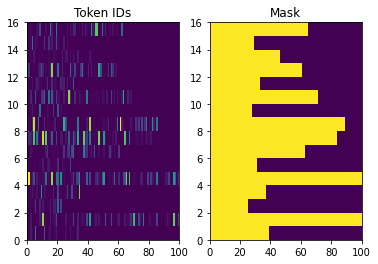

In [53]:
plt.subplot(1, 2, 1)
plt.pcolormesh(item_doc[0])
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(item_doc[0] != 0)
plt.title('Mask')

### Converting ID to Vector

In [54]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[user_doc[3282][0].numpy()]
' '.join(tokens)

'[START] just another flavor of kit [UNK] but the taste is unique and a bit different . the only thing that is [UNK] is the price . i thought it was a bit expensive . . . . [END]                                                             '

# **Context-aware Matrix Factorization for Rating Prediction**

In [55]:
#hyperparameters
num_users=user_df.shape[0]
num_items=item_df.shape[0]
feature_num=16


In [56]:
user_specific_vector = tf.Variable(np.zeros(shape=(num_users, feature_num),dtype=np.float32)) 
item_specific_vector = tf.Variable(np.zeros(shape=(num_items, feature_num),dtype=np.float32)) 

## **PMF (Probabilistic Matrix Factorization)**

In [57]:
class PMF():
    def __init__(self, num_feat=16, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=152, batch_size=1000,num_item=9000,num_user=15000,mean_inv=3):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.num_item=num_item
        self.num_user=num_user
        self.V =  0.1 * np.random.randn(self.num_item, self.num_feat).astype(np.float64)  # Item feature vectors
        self.U =  0.1 * np.random.randn(self.num_user, self.num_feat).astype(np.float64)  # User feature vectors
        self.V_inc = np.zeros((self.num_item, self.num_feat),dtype=np.float64)
        self.U_inc = np.zeros((self.num_user, self.num_feat),dtype=np.float64)
        self.rmse_train = []
        self.rmse_test = []
        self.mean_inv= mean_inv  
        
    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    def train(self):
          
            # Shuffle training truples
            shuffled_order = np.arange(train_data.shape[0])  
            np.random.shuffle(shuffled_order)  
            # Batch update
            
            for batch in range(self.num_batches):  
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
              
                batch_idx = np.mod(test, shuffled_order.shape[0])  
            
                batch_UserID = np.array(train_data['userid'][shuffled_order[batch_idx]], dtype='int32')
                batch_ItemID = np.array(train_data['itemid'][shuffled_order[batch_idx]], dtype='int32')
                # Compute Objective Function
               
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                              self.V[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply
                
                rawErr = pred_out - train_data['rating'][shuffled_order[batch_idx]] + self.mean_inv
                
                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.V[batch_ItemID, :]) \
                       + self._lambda * (self.U[batch_UserID, :] - tf.gather(user_specific_vector,batch_UserID).numpy())
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.U[batch_UserID, :]) \
                       + self._lambda * (self.V[batch_ItemID, :] -  tf.gather(item_specific_vector,batch_ItemID).numpy()) 
                       # np.newaxis :increase the dimension
               
                dw_Item = np.zeros((self.num_item, self.num_feat))
                dw_User = np.zeros((self.num_user, self.num_feat))
                
                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
              
                self.V_inc = self.momentum * self.V_inc + self.epsilon * dw_Item / self.batch_size
                self.U_inc = self.momentum * self.U_inc + self.epsilon * dw_User / self.batch_size
                
                self.V = self.V - self.V_inc
                self.U = self.U - self.U_inc
            
                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.U[np.array(train_data['userid'], dtype='int32'), :],
                                                  self.V[np.array(train_data['itemid'], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - train_data['rating'] + self.mean_inv
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.U - user_specific_vector) ** 2 + np.linalg.norm(self.V - item_specific_vector) ** 2)
                   # print("1***************\n",self.U.shape)
                   # print("2***************\n",user_specific_vector.shape)
                    self.rmse_train.append(np.sqrt(obj / train_data.shape[0]))

                # Compute validation error
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.U[np.array(test_data['userid'], dtype='int32'), :],
                                                  self.V[np.array(test_data['itemid'], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - test_data['rating'] + self.mean_inv
                   
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(test_data.shape[0]))

                    # Print info
                    if batch == self.num_batches - 1:
                        print('\nTraining RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))

    def predict(self, invID):
        return np.dot(self.V, self.U[int(invID), :]) + self.mean_inv  # numpy.dot 点乘

    # ****************Set parameters by providing a parameter dictionary.  ***********#

    def topK(self, test_data, k=10):
        inv_lst = np.unique(test_data[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]  # numpy.argsort

        intersection_cnt = {}
        for i in range(test_data.shape[0]):
            if test_data[i, 1] in pred[test_data[i, 0]]:
                intersection_cnt[test_data[i, 0]] = intersection_cnt.get(test_data[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_data[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)


# **Adversarial Seq2Seq Learning**

## **Metrics**

In [58]:
# log files for training and test
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
graph_log_dir = 'logs/graph/' + current_time 
graph_summary_writer = tf.summary.create_file_writer(graph_log_dir)

In [59]:
class PerplexityMetric(tf.keras.metrics.Metric):
    def __init__(self,name='perplexity',**kwargs):
        super().__init__(name=name, **kwargs)
        self.perplexity=self.add_weight(name='pl',initializer='zeros')

    def update_state(self, nll_loss):
        self.perplexity= 2 ** nll_loss

    def result(self):
        return self.perplexity

In [60]:
train_plx_gen_tch = PerplexityMetric(name='generator perplexity')  # teacher forcing mode
train_plx_gen_plc = PerplexityMetric(name='generator perplexity')  # policy gradient mode
train_loss_gen_policy = tf.keras.metrics.Mean('train loss gen policy', dtype=tf.float32)

train_acc_dis = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

## **Recurrent Review Generator**

- it consists of two encoders and one decoder

### **Encoder**

In [61]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, embedding_dim, enc_units):
    super().__init__()
    self.enc_units = enc_units
    self.input_vocab_size = max_vocab_size
    self.embedding = tf.keras.layers.Embedding(max_vocab_size+4, embedding_dim, embeddings_initializer=keras.initializers.Constant(full_embedding_matrix),trainable=False)
    self.gru= tf.keras.layers.Bidirectional(tf.keras.layers.GRU(enc_units,return_state=True,  recurrent_initializer='glorot_uniform' ))


  def call(self, reviews, state=None):
   
    vectors = self.embedding(reviews)
    _,encoder_forward_state,encoder_backward_state  = self.gru(vectors, initial_state=state)
 
    return  tf.concat([ encoder_forward_state, encoder_backward_state],-1)

    

### **Decoder (Generator)**

In [62]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, embedding_dim, dec_units):
    super().__init__()
    self.dec_units = dec_units
    self.output_vocab_size = max_vocab_size
    self.embedding = tf.keras.layers.Embedding(max_vocab_size+4, embedding_dim,embeddings_initializer=keras.initializers.Constant(full_embedding_matrix), trainable=False)
    self.gru=tf.keras.layers.GRU(dec_units , return_state=True,return_sequences=True)
    self.fc = tf.keras.layers.Dense(max_vocab_size, use_bias=False)
    self.sf=tf.keras.layers.Activation('softmax')

  def call(self, decoder_input, context_vector,state=None):

     embedded_input= self.embedding(decoder_input)
     joint_input_context =tf.concat([embedded_input, tf.tile(tf.expand_dims(context_vector,1),[1,embedded_input.shape[1],1])],2 )
     outputs,dec_state =self.gru(joint_input_context, initial_state=state)
     logits = self.fc( outputs)
     prob_dist=self.sf(logits)

     return prob_dist,dec_state

  

In [63]:
class GeneratorLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
   # self.loss = tf.keras.losses.SparseCategoricalCrossentropy( reduction='none')

  def __call__(self, y_true, y_pred):
    # Calculating the loss for a batch of reviews.

    mask = tf.cast(y_true != 0, tf.int32)
    maskoff_ind=tf.reduce_sum(mask)
    a=tf.one_hot(y_true[:maskoff_ind], max_vocab_size, 1.0, 0.0)
    b=tf.math.log( tf.clip_by_value(y_pred[:maskoff_ind], 1e-20, 1.0))
    #print(y_true)
    #print("\n\n\n",a)
    #print("\n\n\n",b)
    c=a * b
   # print("\n\n\n",c)
    loss=-tf.reduce_sum(c) /tf.cast(maskoff_ind,dtype=tf.float32)
   # print(loss)
    return loss

## **Discriminator**

In [64]:
class Discriminator(tf.keras.Model):
    def __init__( self, sequence_length, vocab_size, embedding_dim, filter_sizes, num_filters, l2_reg_lambda=0.0):
      super().__init__()
      self.sequence_length=sequence_length
      self.vocab_size=max_vocab_size
      self.embedding_dim=embedding_dim
      self.filter_sizes=filter_sizes
      self.num_filters= num_filters

      self.embedding = tf.keras.layers.Embedding(max_vocab_size+4, embedding_dim,weights=[full_embedding_matrix],name="discriminator_embedding",trainable=False)
     
      self.conv_unigram= tf.keras.layers.Conv1D(num_filters, filter_sizes[0], activation="tanh",name="conv_unigram")
      self.conv_bigram= tf.keras.layers.Conv1D(num_filters, filter_sizes[1],activation="tanh",name="conv_bigram")
      self.conv_trigram= tf.keras.layers.Conv1D(num_filters, filter_sizes[2],activation="tanh",name="conv_trigram")
      self.conv_fourgram= tf.keras.layers.Conv1D(num_filters, filter_sizes[3],activation="tanh",name="conv_fourgram")
      self.conv_fivegram= tf.keras.layers.Conv1D(num_filters, filter_sizes[4],activation="tanh",name="conv_fivegram")

      self.gmp_unigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_unigram")
      self.gmp_bigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_bigram")
      self.gmp_trigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_trigram")
      self.gmp_fourgram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_fourgram")
      self.gmp_fivegram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_fivegram")

      self.dropout=tf.keras.layers.Dropout(.5,name="dropout")
      self.fc=tf.keras.layers.Dense(1,activation="sigmoid")


    def get_reward(self, discriminator_inputs , context_vector ):
      
      embedded_input= self.embedding(discriminator_inputs)
      # print("\n\n embeded",embeded_input.shape)
      joint_input_context =tf.concat([embedded_input, tf.tile(tf.expand_dims(context_vector,1),[1,embedded_input.shape[1],1])],2 )

      #  print("\n\n joint:",joint_input_context.shape)
      # print(new_vector.shape)
      #new_vector=tf.reshape(new_vector,[new_vector.shape[1],new_vector.shape[2],1])
      #print(new_vector[0])
      # joint_input_context_reshaped=tf.transpose( joint_input_context,perm=[0,2,1])
      #print("\n\n joint reshaped:",joint_input_context_reshaped.shape)

      cv_unigram=self.conv_unigram(joint_input_context)
      cv_bigram=self.conv_bigram(joint_input_context)
      cv_trigram=self.conv_trigram(joint_input_context)
      cv_fourgram=self.conv_fourgram(joint_input_context)
      cv_fivegram=self.conv_fivegram(joint_input_context)

      #print(" cv uni: ",cv_unigram.shape)
      #print(" cv bi: ",cv_bigram.shape)
      #print(" cv tri: ",cv_trigram.shape)
      #print(" cv four: ",cv_fourgram.shape)
      #print(" cv five: ",cv_fivegram.shape)

      #cv_unigram = tf.reshape(cv_unigram,(cv_unigram.shape[1] , cv_unigram.shape[2], 1))
     
      gmp_unigram = self.gmp_unigram(cv_unigram)
     # cv_bigram = tf.reshape(cv_bigram,(cv_bigram.shape[1] , cv_bigram.shape[2], 1))
      gmp_bigram = self.gmp_bigram(cv_bigram)
     # cv_trigram = tf.reshape(cv_trigram,(cv_trigram.shape[1] , cv_trigram.shape[2], 1))
      gmp_trigram =  self.gmp_trigram(cv_trigram)
     # cv_fourgram = tf.reshape(cv_fourgram,(cv_fourgram.shape[1] , cv_fourgram.shape[2], 1))
      gmp_fourgram = self.gmp_fourgram(cv_fourgram)
     # cv_fivegram = tf.reshape(cv_fivegram,(cv_fivegram.shape[1] , cv_fivegram.shape[2], 1))
      gmp_fivegram = self.gmp_fivegram(cv_fivegram)

     # print(gmp_unigram)
      #print(gmp_bigram)
      #print(gmp_trigram)
     # print(gmp_fourgram)
     # print(gmp_fivegram)
      gmp_overal= tf.concat([gmp_unigram,gmp_bigram,gmp_trigram,gmp_fourgram,gmp_fivegram],1)
      #print("gmp :",gmp_overal)
      #training=true must be studied more but i know dropout during test must not be working
      dropout = self.dropout(gmp_overal,training=True)
     # print(dropout)
      ath= self.fc(dropout)
      gc.collect()
     # print(ath)
      return ath[:,0]


In [65]:
class DiscriminatorLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'cross-entropy_loss'
    self.binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy( reduction='none')

  def __call__(self, y_true, y_pred):
    loss = self.binary_cross_entropy_loss(y_true, y_pred)
    return loss

## **Adversarial Training**

In [66]:
#hyperparameter
t_step=1 # teacher forcing training number
g_step=1 # generator training number
d_step=3 # discriminator training number
rollout_num=1
units=int(feature_num/2 )# gru units
batch_size=32
num_batches=int(train_data.shape[0]/batch_size)

In [67]:
class MaskedLossReward(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss_reward'

  def __call__(self, y_true, y_pred,reward):
    # Calculate the loss for each step.

    mask = tf.cast(y_true != 0, tf.int32)
    maskoff_ind=tf.reduce_sum(mask)
    a=tf.one_hot(y_true[:maskoff_ind], max_vocab_size, 1.0, 0.0)
    b=tf.math.log( tf.clip_by_value(y_pred[:maskoff_ind], 1e-20, 1.0))
    aa=tf.reduce_sum( a * b,2)

    aaa=aa*reward[:maskoff_ind]
    loss=- tf.reduce_sum(aaa)  /tf.cast(maskoff_ind,dtype=tf.float32)
    return loss

In [90]:
class Seq2Seq(tf.keras.Model): 
    def __init__(self, latent_dim, num_batches, batch_size, use_tf_function=False):
        super().__init__()
        self.use_tf_function = use_tf_function
        self.num_batches=num_batches
        self.batch_size=batch_size
        self.latent_dim = latent_dim

        self.user_encoder = Encoder(embedding_dim, units)
        self.item_encoder = Encoder(embedding_dim, units)
        self.decoder = Decoder(embedding_dim, units) #generator
        self.discriminator = Discriminator(sequence_length, max_vocab_size, embedding_dim,[1, 2, 3 ,4, 5] ,100)
      
        self.loss_gn=GeneratorLoss()
        self.loss_ds=DiscriminatorLoss()
        self.loss_fn = MaskedLossReward() # generator loss with reward

        self.optimizer_gn=tf.optimizers.Adam()
        self.optimizer_ds=tf.optimizers.Adam()


    def _train_step_gn_teacher(self,  batch_Userdoc_flattened, batch_Itemdoc_flattened,batch_Userdoc,batch_Itemdoc,batch_review,user_review_num,item_review_num):
            with tf.GradientTape() as tape:
  
              user_enc_state = self.user_encoder(tf.reshape( tf.convert_to_tensor(batch_Userdoc_flattened,dtype=tf.int32) ,[user_review_num,review_max_length])) # user vector representations      
              item_enc_state = self.item_encoder(tf.reshape( tf.convert_to_tensor(batch_Itemdoc_flattened,dtype=tf.int32) ,[item_review_num,review_max_length])) # item vector representations
                  
              pointer=0
              user_context_vector=tf.zeros([0,feature_num])
            
              for i,doc in enumerate(batch_Userdoc): 
                user_context_vector=tf.concat([ user_context_vector, tf.reduce_mean(user_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
                pointer +=doc.shape[0]
        
              pointer=0
              item_context_vector=tf.zeros([0,feature_num])
              
              for i,doc in enumerate(batch_Itemdoc): 
                item_context_vector=tf.concat([ item_context_vector, tf.reduce_mean(item_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
                pointer +=doc.shape[0]

              context_vector= tf.concat( [user_context_vector,item_context_vector],1)
        
              loss = tf.constant(0.0)
              dec_pred, dec_state=self.decoder(tf.concat([tf.cast( np.transpose([[2] * batch_size]),dtype=tf.int32 ), batch_review],1) , context_vector)
              
              loss=self.loss_gn(tf.concat([batch_review ,tf.cast( np.transpose([[3] * batch_size]),dtype=tf.int32) ],1),  dec_pred)
            variables =self.user_encoder.trainable_variables + self.item_encoder.trainable_variables + self.decoder.trainable_variables
            gradients = tape.gradient(loss,variables)
            self.optimizer_gn.apply_gradients(zip(gradients, variables))          
            print("gen batch loss in supervised training", loss)
            
            train_plx_gen_tch.update_state(loss)
      
          # returning the probablity distribution over words for a batch of reviews

    def _train_step_gn_policy(self, batch_Userdoc_flattened, batch_Itemdoc_flattened,batch_Userdoc,batch_Itemdoc,user_review_num,item_review_num):
            with tf.GradientTape() as tape:
              user_enc_state = self.user_encoder(tf.reshape( tf.convert_to_tensor(batch_Userdoc_flattened,dtype=tf.int32) ,[user_review_num,review_max_length])) # user vector representations      
              item_enc_state = self.item_encoder(tf.reshape( tf.convert_to_tensor(batch_Itemdoc_flattened,dtype=tf.int32) ,[item_review_num,review_max_length])) # item vector representations                   
              pointer=0
              user_context_vector=tf.zeros([0,feature_num])                
              for i,doc in enumerate(batch_Userdoc): 
                user_context_vector=tf.concat([ user_context_vector, tf.reduce_mean(user_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
                pointer +=doc.shape[0]            
              pointer=0
              item_context_vector=tf.zeros([0,feature_num])                  
              for i,doc in enumerate(batch_Itemdoc): 
                item_context_vector=tf.concat([ item_context_vector, tf.reduce_mean(item_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
                pointer +=doc.shape[0]
              context_vector= tf.concat( [user_context_vector,item_context_vector],1)
              
              dec_state=None
              dec_prob=[]
              generated_samples=tf.cast(tf.constant(np.full((len(batch_Itemdoc),1),2)),dtype=tf.int32)
                  
              for j in range(sequence_length):                      
                  d_prob,dec_state=self.decoder( generated_samples[:,j:j+1], context_vector ,dec_state)
                  dec_prob.append(d_prob[:,-1])
                  #probability distribution of words  
                  # Sample a token from the last distribution
                  new_tokens =tf.random.categorical(d_prob[:,-1],1,dtype=tf.int32)    
                  generated_samples= tf.concat([generated_samples, new_tokens],-1)   
                  del d_prob          
                              
              #generated_samples,context_vector= self.generate_sample(batch_UserID,batch_ItemID)
              #generated_samples=tf.cast(tf.concat([generated_samples,np.transpose([[3] * batch_size])],1),dtype=tf.int32)
        # generating samples
              g_loss = tf.constant(0.0)           

              reward=[]
              with tape.stop_recording():
                for k in range(rollout_num):
                  
                    for given_num in range(1,sequence_length+1):
                      # the generation of first part of seq
                      _, dec_state=self.decoder(generated_samples[:,:given_num], context_vector)

                      # generated probability distribution given the samples
                      dec_rollout_prob=tf.zeros([batch_size,1,max_vocab_size],dtype= tf.float32)                     
                      rollout_samples=tf.zeros([sequence_length-given_num+1, batch_size] ,dtype= tf.int32)                 
                      rd=None

                      if given_num!=sequence_length+2:
                          # sampling seq length - i tokens with the roll out policy 
                        
                          current_input_token=generated_samples[:,given_num-1:given_num]
                          rollout_samples_list =tf.unstack(rollout_samples)                   
                          for j in range(sequence_length-given_num+2):
                              dec_rollout_prob,dec_state=self.decoder( current_input_token, context_vector ,dec_state)
                          
                              # Sample a token
                              current_input_token = tf.random.categorical(dec_rollout_prob[:,0,:],1,dtype=tf.int32) 

                              rollout_samples_list.append(current_input_token[:,0])
                      
                          rollout_samples=tf.stack(tf.transpose(rollout_samples_list))   
                          full_samples= tf.concat([ generated_samples[:,1:given_num], rollout_samples] ,1)
                          dec_rollout_prob=None
                          rollout_samples=None                        
                          gc.collect()
                          gc.collect(0)   
                          gc.collect(1)   
                          gc.collect(2)   

                          #full sample
                          rd=self.discriminator.get_reward(full_samples,context_vector)

                      else:
                          rd=self.discriminator.get_reward(generated_samples[:,1:],context_vector)
                          #  print("size of dis",asizeof.asized(self.discriminator, detail=1).format() )

                    
                      if k==0: 
                          reward.append(rd)
                      else:
                        reward[given_num-1] +=rd  

              reward= tf.stack(reward,1)/ rollout_num # batchsize * seq_length
              g_loss= self.loss_fn(generated_samples[:,1:] , tf.transpose( tf.stack(dec_prob) ,[1,0,2]) , reward)
            variables = self.user_encoder.trainable_variables + self.item_encoder.trainable_variables + self.decoder.trainable_variables 
            gradients = tape.gradient(g_loss, variables)                  
            self.optimizer_gn.apply_gradients(zip(gradients, variables))
            print("gen batch loss in policy gradient training: ",g_loss)
            train_plx_gen_plc.update_state(g_loss)
          
    def _train_step_disc(self):

          with tf.GradientTape() as tape:

            positive_data,positive_user_indices,positive_item_indices = self.sample_real_data() # ground-truth data
            negative_data,negative_user_indices,negative_item_indices = self.sample_fake_data() # machine-generated data
            #data shape (batch_size * seq length)
            whole_user_indices=tf.concat([positive_user_indices,negative_user_indices],0)
            whole_item_indices= tf.concat([positive_item_indices,negative_item_indices],0)

            positive_labels = tf.ones(batch_size, dtype=tf.int32) 
            negative_labels = tf.zeros(batch_size, dtype=tf.int32) 
            labels = tf.concat([positive_labels, negative_labels], 0)

            shuffle_indices = tf.random.shuffle( tf.range(0, len(labels),dtype=tf.int32))
            whole_data = tf.gather(tf.concat([positive_data,negative_data],0),shuffle_indices)    
            labels = tf.gather(labels,shuffle_indices)
            whole_user_indices = tf.gather(whole_user_indices,shuffle_indices)
            whole_item_indices = tf.gather(whole_item_indices,shuffle_indices)
            query_embedding = tf.concat([tf.gather(user_specific_vector , whole_user_indices) ,tf.gather( item_specific_vector , whole_item_indices)], 1)
            # query shape (batch_size ,2.feature_num)
            dis_reward = self.discriminator.get_reward( whole_data,query_embedding)

            #for i in range(real_data_num+fake_data_num):
              #print(tf.convert_to_tensor( whole_data[i]))
              #print(whole_user_indices[i])
              # print(user_specific_vector[whole_user_indices[i] ])
              #reward.append([0][0].numpy() )
            #print(reward)
            disc_loss=self.loss_ds(labels,dis_reward)
          variables = self.discriminator.trainable_variables 
          # print(variables)
          gradients = tape.gradient(disc_loss, variables)
          # print("************************* gradient :",gradients)
          self.optimizer_ds.apply_gradients(zip(gradients, variables))
          #calculate loss and gradient
          print("disc loss: ",disc_loss)

          train_acc_dis.update_state(labels,dis_reward)

    def sample_real_data(self):

      sample = train_data[np.random.choice(range(0,train_data.shape[0]),batch_size)][['userid','itemid','review']]

      return   tf.stack(sample['review']) ,sample['userid'], sample['itemid']
 
    def sample_fake_data(self):
                

      drawn_userid = np.random.choice(range(0,num_users),batch_size).astype('int32')
      drawn_itemid = np.random.choice(range(0,num_items),batch_size).astype('int32')    
      sample,_= self.generate_sample(drawn_userid,drawn_itemid)

      return sample,drawn_userid,drawn_itemid

    def generate_sample(self,batch_UserID, batch_ItemID):
        
        batch_Userdoc=[user_doc[i] for i in batch_UserID]
        batch_Itemdoc=[item_doc[i] for i in batch_ItemID]
        user_review_num=np.sum([it.shape[0] for it in batch_Userdoc])
        item_review_num=np.sum([it.shape[0] for it in batch_Itemdoc])
        batch_Userdoc_flattened= []
        for i, doc in enumerate(batch_Userdoc):
            batch_Userdoc_flattened=np.append(batch_Userdoc_flattened, doc)
        batch_Itemdoc_flattened= []
        for i, doc in enumerate(batch_Itemdoc):
            batch_Itemdoc_flattened=np.append(batch_Itemdoc_flattened, doc)
        user_enc_state = self.user_encoder(tf.reshape(batch_Userdoc_flattened.astype(int),[user_review_num,review_max_length])) # user vector representations      
        item_enc_state = self.item_encoder(tf.reshape(batch_Itemdoc_flattened.astype(int),[item_review_num,review_max_length])) # item vector representations
      
        pointer=0
        user_context_vector=tf.zeros([0,feature_num])

        for i,doc in enumerate(batch_Userdoc): 
          user_context_vector=tf.concat([ user_context_vector, tf.reduce_mean(user_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
          pointer +=doc.shape[0]
    
        pointer=0
        item_context_vector=tf.zeros([0,feature_num])

        for i,doc in enumerate(batch_Itemdoc): 
          item_context_vector=tf.concat([ item_context_vector, tf.reduce_mean(item_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
          pointer +=doc.shape[0]

        context_vector= tf.concat( [user_context_vector,item_context_vector],1)
        
        dec_state=None
        dec_prob=[]
        dec_out=tf.constant(np.full((len(batch_Itemdoc),1),2),dtype=tf.int32)
            
        for j in range(sequence_length):           
            dec_prob,dec_state=self.decoder( dec_out[:,j:j+1], context_vector ,dec_state)
            #probability distribution of words  
            # Sample a token from the last distribution
            new_tokens =tf.random.categorical(dec_prob[:,-1],1,dtype=tf.int32)    
            dec_out= tf.concat([dec_out, new_tokens],-1)   
        
            del dec_prob          
            del new_tokens 

        gc.collect()  
        return dec_out[:,1:],context_vector

    # def generate_incompleted_sample(self, context_vector,partial_sample):
    #   #given a partial sequence as an input for decoder, this function generate a seq with particular length as an output
      
    #     joint_dec_inputs_context=self.decoder.concat_input_context(partial_sample, context_vector) 
      
    #     dec_result, dec_state=self.decoder(joint_dec_inputs_context)
    #     gc.collect()
    #     #print("incomplete",tracemalloc.get_traced_memory())

    #     return dec_result,dec_state

    # def rollout(self,dec_st,context_vector, initial_token,initial_index):
    #     dec_state=dec_st
    #     dec_pr=np.zeros([sequence_length-initial_index,self.batch_size,1,max_vocab_size],dtype= np.float32)
    #     dec_out=initial_token
    #     joint_dec_inputs_context=None
    #     new_tokens=None
    #     for j in range(sequence_length-initial_index):


    #         joint_dec_inputs_context=self.decoder.concat_input_context(dec_out[:,-1:], context_vector )


    #         dec_pr[j],dec_state=self.decoder( joint_dec_inputs_context ,dec_state)
            
    #         #probability distribution of words  
    #         # Sample a token
    #         new_tokens =tf.random.categorical(dec_pr[j,:,0],1,dtype=tf.int32)  
    #         #print('120', psutil.virtual_memory()[2])
    #         dec_out= tf.concat([dec_out, new_tokens],-1)  
    #         #print('123', psutil.virtual_memory()[2])
          
    #         joint_dec_inputs_context=None
            
    #         gc.collect()


    #     self.dec_prob=tf.transpose(dec_pr,[2,1,0,3])[0]
    #     dec_pr=None 
    #     gc.collect()
      
    #     print('roll out end', psutil.virtual_memory()[2])

    #     #print(dec_out)
    #     # print("\n\n\n",dec_prob)
    #     return dec_out[:,1:]
    def train(self):
        tf.profiler.experimental.start('logs')

        for batch_step in range(4):
          with tf.profiler.experimental.Trace("train",step_num=batch_step, _r=1):
            print("\nstep number : ",batch_step)
            (batch_UserID,batch_ItemID,batch_rating,batch_review) = next(iter(train_ds))
            
            batch_Userdoc=[user_doc[i] for i in batch_UserID]
            batch_Itemdoc=[item_doc[i] for i in batch_ItemID]
            user_review_num=np.sum([it.shape[0] for it in batch_Userdoc],dtype=int)
            item_review_num=np.sum([it.shape[0] for it in batch_Itemdoc],dtype=int)

            batch_Userdoc_flattened= []
            for i, doc in enumerate(batch_Userdoc):
                batch_Userdoc_flattened=np.append(batch_Userdoc_flattened, doc)

            batch_Itemdoc_flattened= []
            for i, doc in enumerate(batch_Itemdoc):
                batch_Itemdoc_flattened=np.append(batch_Itemdoc_flattened, doc)



            # t step generator training teacher forcing
            for _ in range(t_step): 
              self._train_step_gn_teacher(batch_Userdoc_flattened,batch_Itemdoc_flattened,batch_Userdoc,batch_Itemdoc,batch_review,user_review_num,item_review_num)
              
            # g step generator training policy gradient    
            for _ in range(g_step):             
              self._train_step_gn_policy(batch_Userdoc_flattened,batch_Itemdoc_flattened,batch_Userdoc,batch_Itemdoc,user_review_num,item_review_num)  
             
            # d step discriminator training
            for _ in range(d_step):
                self._train_step_disc()


            with train_summary_writer.as_default():
                  tf.summary.scalar('Training perplexity for generator in Teacher Forcing mode', train_plx_gen_tch.result(), step=int(ckpt.step))
                  tf.summary.scalar('Training perplexity for generator in Policy Gradient mode', train_plx_gen_plc.result(), step=int(ckpt.step))
                  tf.summary.scalar('Training accuracy for discriminator', train_acc_dis.result(), step=int(ckpt.step))
        
        tf.profiler.experimental.stop()
    



# **Multi-Task Learning**

In [91]:
class MultiTaskModel(tf.keras.Model):
      def __init__(self):
        super().__init__()
        self.pmf_model=PMF(num_feat=feature_num,maxepoch=100,num_item=len(item_to_column) ,num_user=len(user_to_row), mean_inv=np.mean(train_data['rating']))
        self.seq2seq_model=Seq2Seq(embedding_dim,num_batches,batch_size)      

      def train(self,n_epochs):    
          ckpt.restore(manager.latest_checkpoint)
          if manager.latest_checkpoint:
            print("Restored from {}".format(manager.latest_checkpoint))
          else:
            print("Initializing from scratch.")

          for epoch in range(n_epochs):
              print("\n\nepoch : ", int(ckpt.step))
            
              print("********************************************* \nPMF Model Training Turn =>")
              self.pmf_model.train()
              print("********************************************* \nSeq2Seq Model Training Turn =>")                                         
              self.seq2seq_model.train( )
            
              ckpt.step.assign_add(1)
              save_path = manager.save()
              print("Saved checkpoint for epoch {}: {}".format(int(ckpt.step), save_path))
            # with graph_summary_writer.as_default():
            #     tf.summary.trace_export('seq2seq train step',profiler_outdir=graph_log_dir,step=epoch)


In [92]:
gc.collect()
gc.collect(0)
gc.collect(1)
gc.collect(2)

# creating an instance of Multi_Task Model
mt_model = MultiTaskModel()
ckpt = tf.train.Checkpoint(step=tf.Variable(0), optimizer=tf.keras.optimizers.Adam(), net=mt_model)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=30)


In [93]:
mt_model.train(n_epochs=2)

Restored from ./tf_ckpts/ckpt-6


epoch :  6
********************************************* 
PMF Model Training Turn =>

Training RMSE: 1.088599, Test RMSE 1.081316
********************************************* 
Seq2Seq Model Training Turn =>


2022-11-16 12:05:55.947725: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-16 12:05:55.947801: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-16 12:05:55.948012: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-16 12:05:55.948223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory



step number :  0
gen batch loss in supervised training tf.Tensor(8.199638, shape=(), dtype=float32)
gen batch loss in policy gradient training:  tf.Tensor(5.3772206, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.0039768843, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.0060112732, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.003760762, shape=(), dtype=float32)

step number :  1
gen batch loss in supervised training tf.Tensor(8.189674, shape=(), dtype=float32)
gen batch loss in policy gradient training:  tf.Tensor(5.2174034, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.018634222, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.0031075657, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.013056725, shape=(), dtype=float32)

step number :  2
gen batch loss in supervised training tf.Tensor(8.178998, shape=(), dtype=float32)
gen batch loss in policy gradient training:  tf.Tensor(5.234179, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.010677272, shape=(), dtype=float32)
di

2022-11-16 12:06:52.556968: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-16 12:06:52.567937: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-16 12:06:53.171230: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 98817 callback api events and 97817 activity events. 
2022-11-16 12:06:55.055135: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-16 12:06:57.477218: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/2022_11_16_12_06_55

2022-11-16 12:06:59.316027: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/plugins/profile/2022_11_16_12_06_55/mobin-vivobook.trace.json.gz
2022-11-16 12:07:00.966967: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/

Saved checkpoint for epoch 7: ./tf_ckpts/ckpt-7


epoch :  7
********************************************* 
PMF Model Training Turn =>

Training RMSE: 1.085093, Test RMSE 1.081303
********************************************* 
Seq2Seq Model Training Turn =>

step number :  0


2022-11-16 12:07:02.585432: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-16 12:07:02.585485: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


gen batch loss in supervised training tf.Tensor(8.139611, shape=(), dtype=float32)
gen batch loss in policy gradient training:  tf.Tensor(4.995831, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.0075292327, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.03690392, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.0030809348, shape=(), dtype=float32)

step number :  1
gen batch loss in supervised training tf.Tensor(8.124789, shape=(), dtype=float32)
gen batch loss in policy gradient training:  tf.Tensor(4.8410587, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.014208645, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.0050380765, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.0065654553, shape=(), dtype=float32)

step number :  2
gen batch loss in supervised training tf.Tensor(8.10791, shape=(), dtype=float32)
gen batch loss in policy gradient training:  tf.Tensor(4.6994424, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.013080272, shape=(), dtype=float32)
disc loss:  tf.Tensor

2022-11-16 12:07:58.624631: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-16 12:07:58.635725: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-16 12:07:59.234342: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 98725 callback api events and 97724 activity events. 
2022-11-16 12:08:01.112179: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-16 12:08:03.433129: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/2022_11_16_12_08_01

2022-11-16 12:08:05.279853: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/plugins/profile/2022_11_16_12_08_01/mobin-vivobook.trace.json.gz
2022-11-16 12:08:06.863499: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/

Saved checkpoint for epoch 8: ./tf_ckpts/ckpt-8


# **Ploting Results**

In [94]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [95]:
%tensorboard --logdir logs


Reusing TensorBoard on port 6006 (pid 20875), started 0:24:28 ago. (Use '!kill 20875' to kill it.)

# test code

In [96]:
log_ps, mse_train, mse_test= pm.train(10)

NameError: name 'pm' is not defined

In [ ]:

dec_result,dec_state=decoder(dec_output_tokens,dec_output_tokens,context_vector= user_context_vector,state=dec_state)
sampled_token = tf.random.categorical(dec_result[:,-1, :], num_samples=1)
print( sampled_token.numpy())
dec_output_tokens=np.append( dec_output_tokens , sampled_token.numpy()[0])
print(dec_output_tokens)



In [ ]:
dec_output_tokens

In [ ]:
sampled_token = tf.random.categorical(dec_result[:, -1, :], num_samples=1)
sampled_token.numpy()

In [ ]:
vocab = np.array(input_text_processor.get_vocabulary())
first_word = vocab[dec_output_tokens]
first_word